<a href="https://colab.research.google.com/github/ctorney/abc-collective-movement/blob/main/two_parameter_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#zonal model inference with linear regression on summary stats
import os, sys
import numpy as np
from getpass import getpass
from math import *
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_palette("muted")
plt.style.use('seaborn-whitegrid') 
plt.style.use('seaborn-paper') 
from tqdm import tqdm
import scipy
%matplotlib inline
import matplotlib.ticker as ticker


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#!pip install -qq SALib
sys.path.append('..')

# import SALib

# from SALib.sample import saltelli
# from SALib.analyze import sobol

from tensorflow.keras import Model

from simulations import zonal_gnn
from gpabc import gp_abc
from gpabc import am_sampler

from scipy.stats import gaussian_kde

import pickle

#from graph_network import EncodeProcessDecode

import tensorflow as tf

In [2]:
# import tensorflow as tf

In [3]:
#!pip install GPy

In [4]:
max_params = np.array([25.0,25.0],dtype=np.float32)
MAX_RADIUS=250.
DOMAIN_SIZE=100.

def _parse_graph(inputs):
    #inputs, targets = x
    X, V, A = inputs
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx) 
    dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx) 

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy) 
    dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy) 

    Vx = tf.expand_dims(V[...,0],-1)
    dvx = -Vx + tf.linalg.matrix_transpose(Vx)

    Vy = tf.expand_dims(V[...,1],-1)
    dvy = -Vy + tf.linalg.matrix_transpose(Vy)
    
    dvnorm = tf.math.sqrt(dvx**2+dvy**2)
    dvx = tf.math.divide_no_nan(dvx,dvnorm)
    dvy = tf.math.divide_no_nan(dvy,dvnorm)

    angles = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx) 

    rel_angle_to_neigh = angle_to_neigh - angles

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    adj_matrix = tf.where(dist<MAX_RADIUS, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
    output_ie = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_edge)


    senders =tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

    output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
    edge_distance = tf.expand_dims(tf.gather_nd(dist/MAX_RADIUS, sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
    edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

    edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
    edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


    output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)

    node_velocities = tf.reshape(V,(-1,2))
    node_accelerations = tf.reshape(A,(-1,2))

    #output_x = tf.concat([node_velocities,node_accelerations],axis=-1)
    output_x = node_velocities

    return output_x, output_a, output_e, output_i,output_ie#), targets/max_params
    

In [5]:
gnn_model = tf.keras.models.load_model('gnn/gnn_model')





2022-05-11 13:16:55.659706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 13:17:01.517417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:3b:00.0, compute capability: 6.0


In [6]:
L= 100
N= 100 
repeat = 100
discard = 2000
timesteps = 1
save_interval=1
dt=0.1 


data_sim = zonal_gnn.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval,disable_progress=False)


va=1.5*pi
lrep= 1


latt= 6
lali= 10



data_sim.run_sim(lrep, lali, latt, va)

100%|██████████| 2001/2001 [00:03<00:00, 504.96it/s]


In [7]:
lrep, lali, latt, va

(1, 10, 6, 4.71238898038469)

In [8]:
# X = data_sim.micro_state[0,:,:,:2]
# V = data_sim.micro_state[0,:,:,2:4]
# A = data_sim.micro_state[0,:,:,4:]
# gnn_model(_parse_graph([X,V,A]))

In [9]:


data_sum_stats = []

for i in range(repeat):

    X = data_sim.micro_state[i,:,:,:2]
    V = data_sim.micro_state[i,:,:,2:4]
    A = data_sim.micro_state[i,:,:,4:]
    
    
    data_sum_stats.append(gnn_model(_parse_graph([X,V,A])).numpy())

macrodata = np.array(data_sum_stats).reshape((-1,2))


In [10]:
#databatch[0]

In [11]:
#_parse_graph([X,V,A])

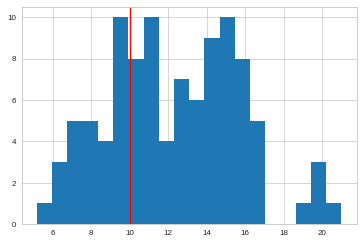

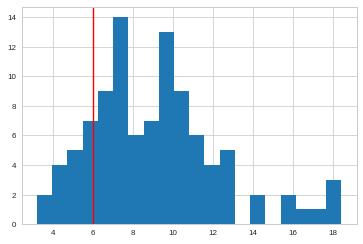

In [12]:
plt.hist(macrodata[:,0],bins=20)
plt.axvline(lali,c='r')
plt.show()


plt.hist(macrodata[:,1],bins=20)
plt.axvline(latt,c='r')
plt.show()

In [13]:
# gnn_model(_parse_graph([X,V,A])

In [14]:

# import os, sys
# import numpy as np
# from math import *
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# import tensorflow as tf

# from scipy import stats

# import pickle



# from tensorflow.keras import Model
# from tensorflow.keras.layers import Dense, Input, Concatenate
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.optimizers import Adam

# from spektral.layers import ECCConv, GlobalAvgPool, MessagePassing, XENetConv, GlobalAttentionPool, GlobalMaxPool, GlobalSumPool,GlobalAttnSumPool

# plt.style.use('ggplot')
# plt.style.use('seaborn-paper') 
# plt.style.use('seaborn-whitegrid') 



# #************************************
# #************************************
# #********DATA LOADER*****************
# #************************************
# #************************************
# #************************************

# train_dir = 'train_datasets/'
# valid_dir = 'valid_datasets/'

# BATCH_SIZE=2
# EPOCHS=200

# all_file_list = [train_dir + filename for filename in os.listdir(train_dir)]

# dataset_size = sum(1 for _ in tf.data.TFRecordDataset(all_file_list[0]))*len(all_file_list)//BATCH_SIZE


# feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
#                         'timestep': tf.io.FixedLenFeature([], tf.int64),
#                         'parameter_vector': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
#                         'pos': tf.io.FixedLenFeature([], tf.string),
#                         'vel': tf.io.FixedLenFeature([], tf.string),
#                         'acc': tf.io.FixedLenFeature([], tf.string)}

# def _parse_record(x):
#   # Parse the input tf.train.Example proto using the dictionary above.
#   return tf.io.parse_single_example(x, feature_description)

# def _parse_tensor(x):
#     output = {'group_id': x['group_id'],
#                 'timestep': x['timestep'],
#                 'parameter_vector': x['parameter_vector'],
#                 'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
#                 'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32),
#                 'acc': tf.io.parse_tensor(x['acc'],out_type=tf.float32)}
#     return output

# def _parse_keras(x):
#     pos = x['pos']
#     #pos.set_shape((None,2))
#     vel = x['vel']
#     #vel.set_shape((None,2))
#     acc = x['acc']
#     #acc.set_shape((None,2))
    
#     target = x['parameter_vector'][1:3]
#     #target.set_shape((4))
#     output = ((pos,vel,acc),target)
#     return output


# DOMAIN_SIZE=200.
# MAX_RADIUS=25.

# max_params = np.array([25.0,25.0],dtype=np.float32)

# def _parse_graph(inputs, targets):
#     #inputs, targets = x
#     X, V, A = inputs
    
#     Xx = tf.expand_dims(X[...,0],-1)
#     dx = -Xx + tf.linalg.matrix_transpose(Xx)
#     dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx)
#     dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx)

#     Xy = tf.expand_dims(X[...,1],-1)
#     dy = -Xy + tf.linalg.matrix_transpose(Xy)
#     dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy)
#     dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy)

#     Vx = tf.expand_dims(V[...,0],-1)
#     dvx = -Vx + tf.linalg.matrix_transpose(Vx)

#     Vy = tf.expand_dims(V[...,1],-1)
#     dvy = -Vy + tf.linalg.matrix_transpose(Vy)
    
#     dvnorm = tf.math.sqrt(dvx**2+dvy**2)
#     dvx = tf.math.divide_no_nan(dvx,dvnorm)
#     dvy = tf.math.divide_no_nan(dvy,dvnorm)

#     angles = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
#     angle_to_neigh = tf.math.atan2(dy, dx)

#     rel_angle_to_neigh = angle_to_neigh - angles

#     dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

#     adj_matrix = tf.where(dist<MAX_RADIUS, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
#     adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
#     sender_recv_list = tf.where(adj_matrix)
#     n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
#     n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

#     output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
#     output_ie = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_edge)


#     senders =tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
#     receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

#     output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
#     edge_distance = tf.expand_dims(tf.gather_nd(dist/MAX_RADIUS, sender_recv_list),-1)
#     edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
#     edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

#     edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
#     edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


#     output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)

#     node_velocities = tf.reshape(V,(-1,2))
#     node_accelerations = tf.reshape(A,(-1,2))

#     output_x = tf.concat([node_velocities,node_accelerations],axis=-1)

#     return (output_x, output_a, output_e, output_i,output_ie), targets/max_params
    
    



# valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

# parsed_valid_dataset = valid_dataset.map(_parse_record)
# parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
# parsed_valid_dataset = parsed_valid_dataset.map(_parse_keras)
# parsed_valid_dataset = parsed_valid_dataset.batch(BATCH_SIZE, drop_remainder=True)
# #parsed_valid_dataset = parsed_valid_dataset.map(_parse_graph)



# for databatch in tqdm(parsed_valid_dataset):
#     break

# # gnn_model = tf.keras.models.load_model('gnn/gnn_model')

# # #************************************
# # #************************************
# # #********SAVE FIGURE*****************
# # #************************************
# # #************************************
# # #************************************


    
    
# # pred_list = []
# # true_values = []
# # for databatch in tqdm(parsed_valid_dataset):

# #     target = databatch[1]/max_params
# #     true_values.append(target.numpy())


# #     predictions = gnn_model((databatch[0]))
# #     pred_list.append(np.squeeze(predictions.numpy()))
# # #     break

# # # print(target, predictions)

# # # for databatch in tqdm(parsed_valid_dataset2):

# # #     target = databatch[1]
# # #     true_values.append(target.numpy())


# # #     predictions = gnn_model(databatch[0])
# # #     pred_list.append(np.squeeze(predictions.numpy()))
# # #     break

# # # print(target, predictions)


# # fig, axs = plt.subplots(1,2, figsize=(8, 3), facecolor='w', edgecolor='k')  

# # axs = axs.ravel()
# # for pred_i in range(2):

# #     pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
# #     true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

# #     bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
# #     bin_width = (bin_edges[1] - bin_edges[0])
# #     bin_centers = bin_edges[1:] - bin_width/2

# #     bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


# #     axs[pred_i].plot(bin_centers,bin_means,c='C0')

# #     axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

# #     xx = np.linspace(0,true_vals.max(),10)
# #     axs[pred_i].plot(xx,xx,c='k',ls='--')

# #     axs[pred_i].set_ylabel('GNN prediction of parameter')
# #     axs[pred_i].set_xlabel('True parameter that generated the microstate')



# # # plt.savefig('gnn_trained.png',dpi=300)


In [15]:
#databatch

In [16]:
# plt.plot(true_vals,pred_vals,'.')

In [17]:
# target

In [18]:
# target*25

In [19]:
# predictions

In [107]:

# data_sum_stats = []

# for i in range(repeat):

#     X = data_sim.micro_state[i,:,:,:2]
#     V = data_sim.micro_state[i,:,:,2:4]
#     A = data_sim.micro_state[i,:,:,4:]
    
    
#     data_sum_stats.append(gnn_model(_parse_graph([X,V,A])).numpy())#[:,1:3])
 

# macrodata=np.array(data_sum_stats).reshape((-1,2))

In [108]:
#macrodata

In [109]:


# data_sum_stats = []

# for i in range(repeat):

#     X = data_sim.micro_state[i,:,:,:2]
#     V = data_sim.micro_state[i,:,:,2:4]
#     A = data_sim.micro_state[i,:,:,4:]
    
    
#     data_sum_stats.append(gnn_model(_parse_graph([X,V,A])).numpy())#[:,1:3])
 

# macrodata=np.array(data_sum_stats).reshape((-1,2))
# plt.hist(macrodata[:,0],bins=50)
# #plt.axvline(4,c='r')
# plt.show()


# plt.hist(macrodata[:,1],bins=50)
# #plt.axvline(6,c='r')
# plt.show()

In [110]:
# ss_0 = macrodata
# theta_DATA0 = np.mean(ss_0,axis=0) 
# sd0 =  np.std(ss_0,axis=0) 
# cov = np.diag(sd0**2)
# sd0.shape[0]

In [111]:
# scipy.stats.multivariate_normal(theta_DATA0,1).pdf(sim_output).shape

In [112]:
# ss_0

In [113]:
# theta_DATA0*[5,15,25,6.28]
#[1.        5.5898438 6.9765625 6.2831855]

In [114]:
# #macrodata = macrodata.T
# # cov
# lrep

# sim_output = simulator_2d([4.6,2.4])

In [15]:
# macrodata.shape
# np.std(macrodata,axis=0).mean()

In [37]:
#aaa = simulator_2d([25.,0.])

In [38]:
#aaa

In [14]:
# sum_stats = []


# for i in range(repeat):

#     X = aaa.micro_state[i,:,:,:2]
#     V = aaa.micro_state[i,:,:,2:4]
#     A = aaa.micro_state[i,:,:,4:]


#     sum_stats.append(gnn_model(_parse_graph([X,V,A])).numpy())#[:,1:3])

In [16]:
# data_vector
# np.std(macrodata,axis=0)

# np.linalg.det(cov)
# abc_likelihood_2d(aaa)

In [13]:
repeat = 500    

data_vector = np.mean(macrodata,axis=0) 
#cov = np.std(macrodata,axis=0).mean()**2
sd0 =  np.std(macrodata,axis=0) 
cov = np.diag(sd0**2)
def abc_likelihood_2d(sim_output):
    #ss_0 = macrodata
    #'theta_DATA0 = np.mean(ss_0,axis=0) 
    #'sd0 =  np.std(ss_0,axis=0) 
    #'cov = np.diag(sd0**2)
    repeat = sim_output.shape[0]
    k = sim_output.shape[1]
    
    return np.log(1e-18 + 1/repeat * (((2*pi*np.product(sd0))**k)**0.5)*np.sum(scipy.stats.multivariate_normal(data_vector,cov).pdf(sim_output)))


sim = zonal_gnn.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval,disable_progress=True, save_micro=False)

def simulator_2d(params):
    


    
    sim.run_sim(lrep, params[0], params[1], va)
    
    
    sum_stats = []


    for i in range(repeat):

        X = sim.micro_state[i,:,:,:2]
        V = sim.micro_state[i,:,:,2:4]
        A = sim.micro_state[i,:,:,4:]


        sum_stats.append(gnn_model(_parse_graph([X,V,A])).numpy())#[:,1:3])

    return np.array(sum_stats).reshape((-1,2))

In [17]:
# sim_output = data_vector[None]
# repeat = sim_output.shape[0]
# k = sim_output.shape[1]
    
# (((2*pi*np.product(sd0))**k)**0.5)*np.sum(scipy.stats.multivariate_normal(data_vector,cov).pdf(sim_output))


In [18]:


# abc_likelihood_2d(data_vector[None])

# data_vector

In [19]:
# params = [10.0,6.0]
# ali_list = np.arange(1.0,15.0,1.)
# for i in range(ali_list.shape[0]):
#     params[0] = ali_list[i]
#     print(params[0], abc_likelihood_2d(simulator_2d(params)))

In [34]:
# abcGP.sobel_range


# points_per_dim = ((len(gp)+1)*(abcGP.n_points-1))**(1/abcGP.input_dim)


# for i in range(abcGP.input_dim):
#     print(abcGP.sobel_range[i]/points_per_dim)
# m = abcGP.gp[0][0]

# m.rbf.lengthscale[[0]].constrain_bounded(1,2) 
# #m['.*lengthscale'][[0]].constrain_bounded(1,2) 

# abcGP.l_init

In [20]:
#2D inference of l_ali and eta: 
ndim = 2
p_start = np.array([0.0,0.0])
p_range = np.array([25.0,25.0]) 

# use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
y_previous = np.full((100,100),np.log(1e-18))

# number of waves
n_wave = 10
n_points = 25 
T = 3

# number of points to add per wave
#n_points = 80
#T=0.05

data_lali = lali
data_latt = latt

abcGP = gp_abc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d) #synth_likelihood_function) #likelihood_function)




25it [08:43, 20.94s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


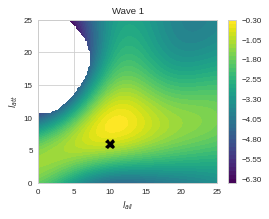

46it [08:46, 11.44s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


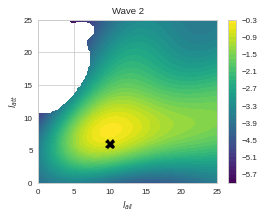

71it [08:47,  7.42s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


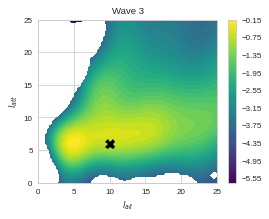

86it [08:53,  6.20s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


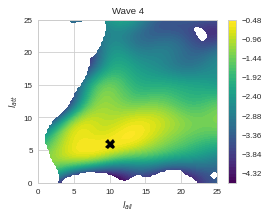

107it [08:54,  5.00s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


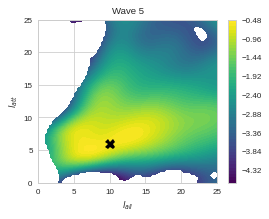

131it [08:49,  4.05s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


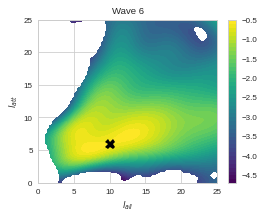

156it [08:53,  3.42s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


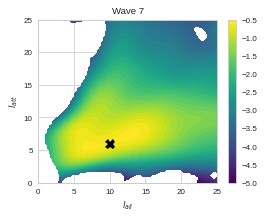

181it [08:45,  2.90s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


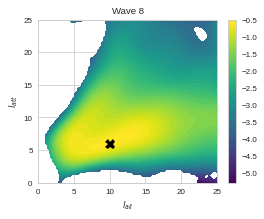

206it [08:46,  2.56s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


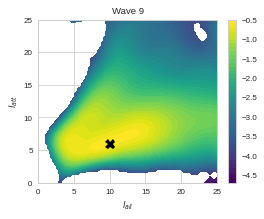

230it [08:51,  2.31s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


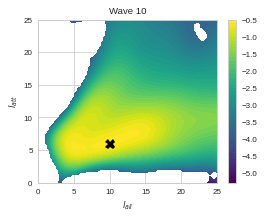

In [21]:
for i in range(n_wave):
    abcGP.runWave()
    plt.figure(figsize=(4,3))
    #plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='b',ms=4)
    abcGP.remove_implausible()
    #plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='r',ms=4)
    
    plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 
    # plot GP output
    xx, yy = np.meshgrid(X[0], X[1], sparse=False)
    x_grid = np.array([xx.flatten(), yy.flatten()]).T
    #if i>0:
    y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
    #else:
    #    y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=False)
    y_pred = y_pred.reshape(100,100)
    # for plotting we'll carry through the implausible regions from previous waves
    #y_pred[np.isinf(y_pred)]=y_previous[np.isinf(y_pred)]
    #y_previous = y_pred.copy()
    h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',vmax=min(0,np.max(y_pred)))  #0.1*
    ax = plt.gca()
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('$l_{ali}$')
    plt.ylabel('$l_{att}$')
    plt.title('Wave {}'.format(i+1))
    plt.colorbar()
    plt.savefig('zonal_macroscale_wave_normal_2D' + str(i) + '.png',dpi=300)

    plt.show()

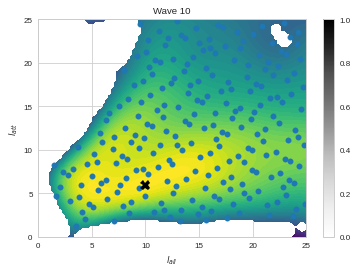

In [22]:
plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 
# plot GP output
xx, yy = np.meshgrid(X[0], X[1], sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()]).T
#if i>0:
y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
#else:

sim_points = abcGP.sobol_points[np.isfinite(abcGP.likelihood)]

#    y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=False)
y_pred = y_pred.reshape(100,100)
# for plotting we'll carry through the implausible regions from previous waves
#y_pred[np.isinf(y_pred)]=y_previous[np.isinf(y_pred)]
#y_previous = y_pred.copy()
h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',vmax=min(0,np.max(y_pred)))  #0.1*

plt.scatter(sim_points[:,0],sim_points[:,1])
ax = plt.gca()
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('$l_{ali}$')
plt.ylabel('$l_{att}$')
plt.title('Wave {}'.format(i+1))
plt.colorbar()
#plt.savefig('zonal_macroscale_wave_normal_2D' + str(i) + '.png',dpi=300)

plt.show()

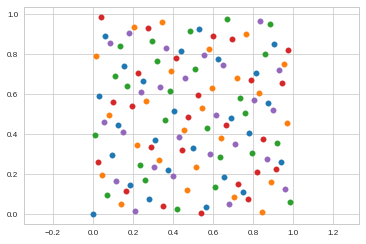

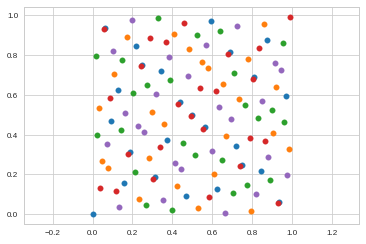

In [90]:
from scipy.stats import qmc

sampler = qmc.Halton(d=2, scramble=False)
#sampler = qmc.Sobol(d=2, scramble=False)
#sampler = qmc.LatinHypercube(d=2,centered=True)
s1 = sampler.random(n=25)
s2 = sampler.random(n=25)
s3 = sampler.random(n=25)
s4 = sampler.random(n=25)
s5 = sampler.random(n=25)

plt.scatter(s1[:,0],s1[:,1])
plt.scatter(s2[:,0],s2[:,1])
plt.scatter(s3[:,0],s3[:,1])
plt.scatter(s4[:,0],s4[:,1])
plt.scatter(s5[:,0],s5[:,1])
plt.axis('equal')
plt.show()


#sampler = qmc.Halton(d=2, scramble=False)
sampler = qmc.Sobol(d=2, scramble=False)
#sampler = qmc.LatinHypercube(d=2,centered=True)
s1 = sampler.random(n=25)
s2 = sampler.random(n=25)
s3 = sampler.random(n=25)
s4 = sampler.random(n=25)
s5 = sampler.random(n=25)

plt.scatter(s1[:,0],s1[:,1])
plt.scatter(s2[:,0],s2[:,1])
plt.scatter(s3[:,0],s3[:,1])
plt.scatter(s4[:,0],s4[:,1])
plt.scatter(s5[:,0],s5[:,1])
plt.axis('equal')
plt.show()

In [55]:
abcGP.sobol_points[np.isfinite(abcGP.likelihood)]


array([[12.5       , 12.5       ],
       [18.75      ,  6.25      ],
       [ 6.25      , 18.75      ],
       [ 9.375     ,  9.375     ],
       [21.875     , 21.875     ],
       [15.625     ,  3.125     ],
       [ 4.6875    ,  7.8125    ],
       [17.1875    , 20.3125    ],
       [23.4375    ,  1.5625    ],
       [10.9375    , 14.0625    ],
       [ 7.8125    ,  4.6875    ],
       [20.3125    , 17.1875    ],
       [14.0625    , 10.9375    ],
       [14.84375   , 24.21875   ],
       [21.09375   ,  5.46875   ],
       [ 8.59375   , 17.96875   ],
       [11.71875   ,  2.34375   ],
       [24.21875   , 14.84375   ],
       [17.96875   ,  8.59375   ],
       [ 3.90625   ,  3.90625   ],
       [16.40625   , 16.40625   ],
       [22.65625   , 10.15625   ],
       [10.15625   , 22.65625   ],
       [ 7.03125   ,  7.03125   ],
       [19.53125   , 19.53125   ],
       [13.28125   ,  0.78125   ],
       [ 1.171875  ,  6.640625  ],
       [13.671875  , 19.140625  ],
       [19.921875  ,

In [23]:

#am_sampler:
Y = abcGP.sobol_points[np.isfinite(abcGP.likelihood)]
logl = abcGP.predict_final(Y)[0]
startval = Y[np.argsort(-logl[:,0])[0]]
#startval = abcGP.sobel_points[np.random.choice(abcGP.sobel_points.shape[0])]
prior = np.array(((0.0,25.0),(0.0,25.0)))  
print(startval)

# step size is 1/50th of the plausible range
steps = np.ptp(abcGP.sobol_points,axis=0)/100
import time
start = time.time()
samples = am_sampler.am_sampler(abcGP.predict_final,2,startval,prior,steps, n_samples=2000, burn_in=10000, m=10)
print(time.time()-start)

[5.56640625 5.34979424]


100%|██████████| 30000/30000 [06:09<00:00, 81.11it/s]

370.27620816230774


In [59]:
#am_sampler:
Y = abcGP.sobol_points[np.isfinite(abcGP.likelihood)]
logl = abcGP.predict_final(Y)[0]
startval = Y[np.argsort(-logl[:,0])[0]]

In [68]:
np.argmax(abcGP.likelihood[np.isfinite(abcGP.likelihood)])
#abcGP.sobol_points[120]
Y[87]

array([10.3515625,  6.4453125])

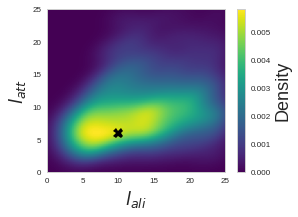

In [24]:
plt.figure(figsize=(4,3))
# fit an array of size [Ndim, Nsamples]
data = np.vstack([samples[:,0],samples[:,1]])
kde = gaussian_kde(data)

# evaluate on a regular grid
#0.55,0.8,0.15,0.25
xgrid = np.linspace(0.0, 25.0, 100) # 0.99, 40)
ygrid = np.linspace(0.0, 25.0, 100) #0.3, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent= [0.0,25.0,0.0,25.0] ,
           cmap='viridis') #[0.55,0.99,0.15,0.3],
plt.grid(False)
plt.xlabel('$l_{ali}$', fontsize=18)
plt.ylabel('$l_{att}$', fontsize=18)
plt.title('', fontsize=18)
cb = plt.colorbar()
cb.set_label("Density", fontsize=18)
plt.savefig('kde_normal_2D.png',bbox_inches = 'tight',dpi=300)
plt.show()

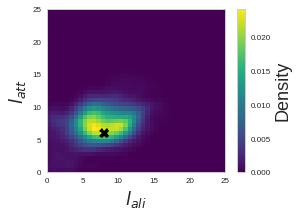

In [22]:
plt.figure(figsize=(4,3))
# fit an array of size [Ndim, Nsamples]
data = np.vstack([samples[:,0],samples[:,1]])
kde = gaussian_kde(data)

# evaluate on a regular grid
#0.55,0.8,0.15,0.25
xgrid = np.linspace(0.0, 25.0, 40) # 0.99, 40)
ygrid = np.linspace(0.0,25.0, 40) #0.3, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent= [0.0,25.0,0.0,25.0] ,
           cmap='viridis') #[0.55,0.99,0.15,0.3],
plt.grid(False)
plt.xlabel('$l_{ali}$', fontsize=18)
plt.ylabel('$l_{att}$', fontsize=18)
plt.title('', fontsize=18)
cb = plt.colorbar()
cb.set_label("Density", fontsize=18)
plt.savefig('kde_normal_2D.png',bbox_inches = 'tight',dpi=300)
plt.show()

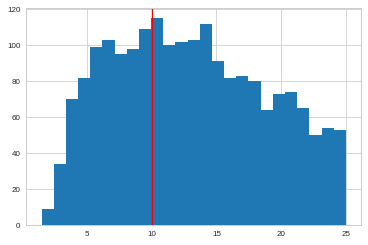

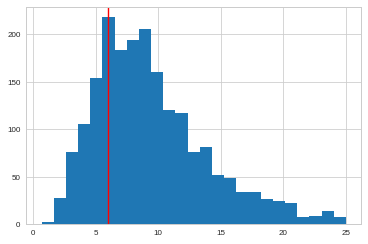

In [25]:
plt.hist(samples[:,0],bins=25)
plt.axvline(data_lali,c='r')

plt.show()


plt.hist(samples[:,1],bins=25)
plt.axvline(data_latt,c='r')

plt.show()



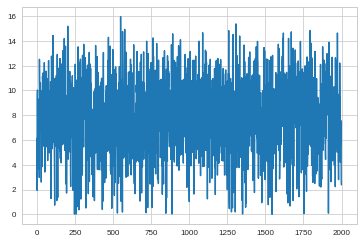

In [28]:
plt.plot(samples[:,0])

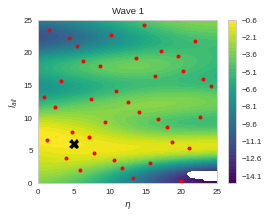

In [46]:
plt.figure(figsize=(4,3))
#plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='b',ms=4)
#abcGP.remove_implausible()
plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='r',ms=4)

plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 
# plot GP output
xx, yy = np.meshgrid(X[0], X[1], sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()]).T
if i>0:
    y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
else:
    y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
y_pred = y_pred.reshape(100,100)
# for plotting we'll carry through the implausible regions from previous waves
#y_pred[np.isinf(y_pred)]=y_previous[np.isinf(y_pred)]
#y_previous = y_pred.copy()
h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',vmax=min(0,np.max(y_pred)))  #0.1*
ax = plt.gca()
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('$\eta$')
plt.ylabel('$l_{ali}$')
plt.title('Wave {}'.format(i+1))
plt.colorbar()
plt.savefig('zonal_macroscale_wave_normal_2D' + str(i) + '.png',dpi=300)

plt.show()

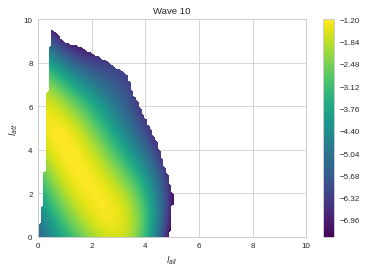

In [17]:
h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',levels=100)#,vmax=-1.2,vmin=-2)  #0.1*
ax = plt.gca()
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('$l_{ali}$')
plt.ylabel('$l_{att}$')
plt.title('Wave {}'.format(i+1))
plt.colorbar()
plt.savefig('zonal_macroscale_wave_normal_2D' + str(i) + '.png',dpi=300)

plt.show()

## Approach 1 - fixed summary statistics

100%|██████████| 5002/5002 [00:15<00:00, 328.26it/s]


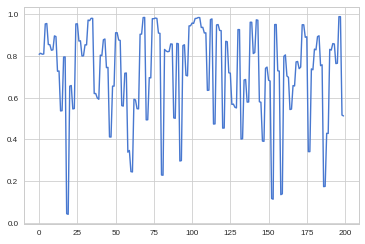

In [2]:

L= 200
discard=5000 
N= 100 #500
repeat = 100 
timesteps = 2 
save_interval=1 #0 #1
dt=0.1 #1 #0.1
simulation_cls = zonal.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval)

latt=6
lrep= 1
lali= 5
eta=0.9
va=2*pi
vs=5
sigma=0.1
simulation_cls.run_sim(eta, latt, lali, lrep, vs, va, sigma)

data_eta=eta
data_va=va
data_latt=latt
data_lali=lali
data_lrep=lrep
data_vs = vs
data_sigma = sigma

DATA_y = [data_lali,data_latt,data_lrep,data_eta,data_vs,data_va,data_sigma]


op, rot, ent, nnd, dis = simulation_cls.get_macro_states()
avgOPDATA=np.zeros(repeat)
avgROTDATA=np.zeros(repeat)
avgENTDATA=np.zeros(repeat)
avgNNDDATA=np.zeros(repeat)
avgDISDATA=np.zeros(repeat)

plt.plot(op)

for i in range(repeat):
    avgOPDATA[i] = op[((i+1)*(timesteps-1))-1]  
    avgROTDATA[i] = rot[((i+1)*(timesteps-1))-1] 
    avgENTDATA[i] = ent[((i+1)*(timesteps-1))-1] 
    avgNNDDATA[i] = nnd[((i+1)*(timesteps-1))-1] 
    avgDISDATA[i] = dis[((i+1)*(timesteps-1))-1] 

macrodata=  np.array([avgOPDATA,avgROTDATA,avgENTDATA,avgNNDDATA,avgDISDATA])



In [3]:

    
def abc_likelihood_2d_no_rc(sim_output,rc):
    theta_0 = sim_output

    ss_0 = macrodata
    theta_DATA0 = np.mean(ss_0,axis=-1) 
    sd0 =  np.std(ss_0,axis=-1) 
    cov = np.diag(sd0**2)
    repeat = sim_output.shape[1]
    
    k = sd0.shape[0]
    return np.log(1e-18 + 1/repeat * (((2*pi)**k)**0.5*np.product(sd0))*np.sum(scipy.stats.multivariate_normal(theta_DATA0,cov).pdf(theta_0.T)))


def simulator_2d(params):
    repeat = 50    
    simulation_cls = zonal.zonal_model(N,timesteps+discard,discard=discard,repeat=repeat,L=L,dt=dt, save_interval=1,disable_progress=True) 

    simulation_cls.run_sim(eta, params[1], params[0],lrep, vs, va, sigma)  
    output = simulation_cls.get_macro_states() 
    
    return np.array(output)
  
# #[sim_output1,np.reshape(sim_output1,(repeat*timesteps)),np.reshape(sim_output2,(repeat*timesteps)),np.reshape(sim_output3,(repeat*timesteps)),np.reshape(sim_output4,(repeat*timesteps)),np.reshape(sim_output5,(repeat*timesteps))]
  

20it [02:32,  7.62s/it]


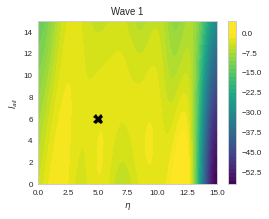

36it [03:49,  6.38s/it]


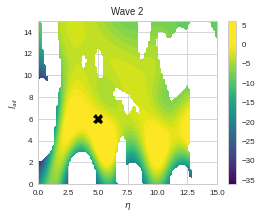

55it [03:18,  3.62s/it]


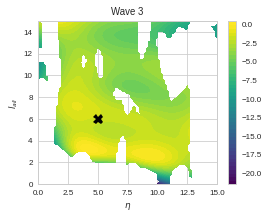

70it [02:48,  2.41s/it]


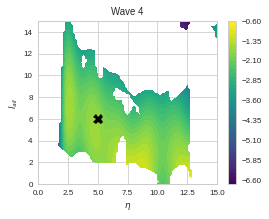

72it [02:57,  2.46s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


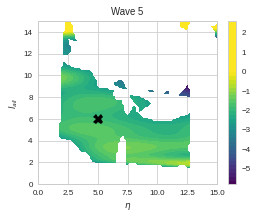

78it [03:04,  2.37s/it]


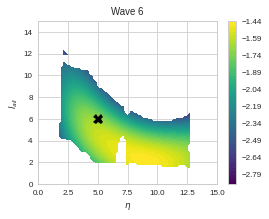

99it [03:13,  1.95s/it]


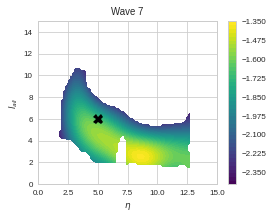

110it [02:50,  1.55s/it]


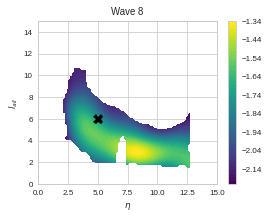

126it [02:42,  1.29s/it]


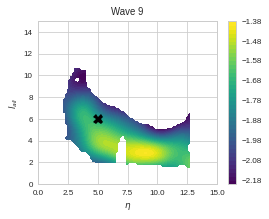

146it [02:35,  1.06s/it]


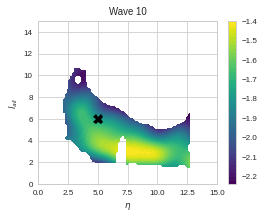

In [4]:
#2D inference of l_ali and eta: 
ndim = 2
p_start = np.array([0.0,0.0])
p_range = np.array([15.0,15.0]) 

# use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
y_previous = np.full((100,100),np.log(1e-18))

# number of waves
n_wave = 10 
n_points = 20 
T = 0.5

# number of points to add per wave
#n_points = 80
#T=0.05

abcGP = gp_abc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d_no_rc) #synth_likelihood_function) #likelihood_function)


for i in range(n_wave):
    abcGP.runWave()
    plt.figure(figsize=(4,3))
    #plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='b',ms=4)
    abcGP.remove_implausible()
    #plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='r',ms=4)
    
    plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 
    # plot GP output
    xx, yy = np.meshgrid(X[0], X[1], sparse=False)
    x_grid = np.array([xx.flatten(), yy.flatten()])
    if i>0:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
    else:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=False)
    y_pred = y_pred.reshape(100,100)
    # for plotting we'll carry through the implausible regions from previous waves
    #y_pred[np.isinf(y_pred)]=y_previous[np.isinf(y_pred)]
    #y_previous = y_pred.copy()
    h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',vmax=min(0,np.max(y_pred)))  #0.1*
    ax = plt.gca()
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('$\eta$')
    plt.ylabel('$l_{ali}$')
    plt.title('Wave {}'.format(i+1))
    plt.colorbar()
    plt.savefig('zonal_macroscale_wave_normal_2D' + str(i) + '.png',dpi=300)

    plt.show()

## Approach 2 - dynamic summary statistics


100%|██████████| 5002/5002 [00:14<00:00, 337.06it/s]


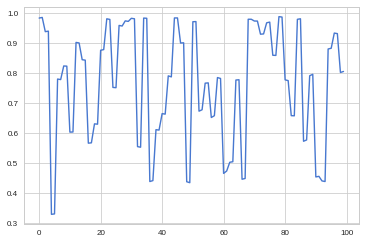

In [5]:

L= 200
discard=5000 
N= 100 #500
repeat = 100#0 
timesteps = 2 
save_interval=1 #0 #1
dt=0.1 #1 #0.1
simulation_cls = zonal.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval)

latt=6
lrep= 1
lali= 5
eta=0.9
va=2*pi
vs=5
sigma=0.1
simulation_cls.run_sim(eta, latt, lali, lrep, vs, va, sigma)

data_eta=eta
data_va=va
data_latt=latt
data_lali=lali
data_lrep=lrep
data_vs = vs
data_sigma = sigma

DATA_y = [data_lali,data_latt,data_lrep,data_eta,data_vs,data_va,data_sigma]


op, rot, ent, nnd, dis = simulation_cls.get_macro_states()
avgOPDATA=np.zeros(repeat)
avgROTDATA=np.zeros(repeat)
avgENTDATA=np.zeros(repeat)
avgNNDDATA=np.zeros(repeat)
avgDISDATA=np.zeros(repeat)


for i in range(repeat):
    avgOPDATA[i] = op[((i+1)*(timesteps-1))-1]  
    avgROTDATA[i] = rot[((i+1)*(timesteps-1))-1] 
    avgENTDATA[i] = ent[((i+1)*(timesteps-1))-1] 
    avgNNDDATA[i] = nnd[((i+1)*(timesteps-1))-1] 
    avgDISDATA[i] = dis[((i+1)*(timesteps-1))-1] 

macrodata=  np.array([avgOPDATA,avgROTDATA,avgENTDATA,avgNNDDATA,avgDISDATA])

plt.plot(avgOPDATA)


In [6]:
def abc_likelihood_2d(sim_output,rc):
    theta_0 = rc@sim_output

    ss_0 = rc@macrodata
    theta_DATA0 = np.mean(ss_0,axis=-1) 
    sd0 =  np.std(ss_0,axis=-1) 
    cov = np.diag(sd0**2)
    repeat = sim_output.shape[1]
    
    k = sd0.shape[0]
    return np.log(1e-18 + 1/repeat * (((2*pi)**k)**0.5*np.product(sd0))*np.sum(scipy.stats.multivariate_normal(theta_DATA0,cov).pdf(theta_0.T)))



def simulator_2d(params):
    repeat = 50
    simulation_cls = zonal.zonal_model(N,timesteps+discard,discard=discard,repeat=repeat,L=L,dt=dt, save_interval=1,disable_progress=True) 

    simulation_cls.run_sim(eta, params[1], params[0],lrep, vs, va, sigma)  
    output = simulation_cls.get_macro_states() 
    
    return np.array(output)
  
  

20it [02:34,  7.73s/it]
37it [00:00, 5249.80it/s]

New regression model coefficient of determination:  [0.38332813 0.42257101]


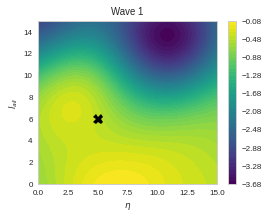

37it [03:13,  5.23s/it]
51it [00:00, 1962.13it/s]

New regression model coefficient of determination:  [0.34489321 0.2909585 ]


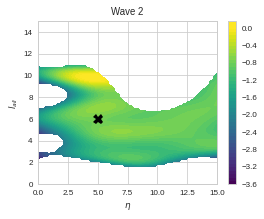

51it [03:12,  3.78s/it]
73it [00:00, 2137.81it/s]

New regression model coefficient of determination:  [0.31380711 0.26435909]


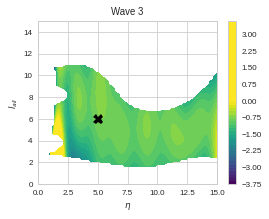

73it [03:05,  2.54s/it]
88it [00:00, 2588.77it/s]

New regression model coefficient of determination:  [0.24188247 0.27296594]


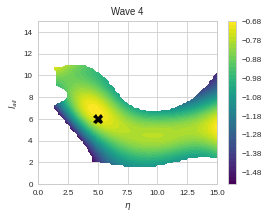

88it [02:35,  1.77s/it]
108it [00:00, 2593.24it/s]

New regression model coefficient of determination:  [0.25275593 0.26984558]


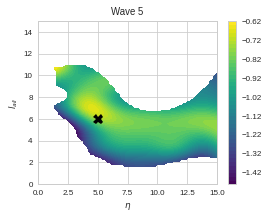

108it [02:42,  1.50s/it]
127it [00:00, 1370.57it/s]

New regression model coefficient of determination:  [0.23407899 0.26860157]


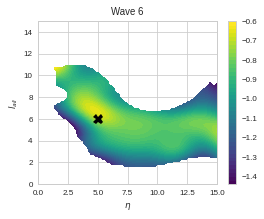

127it [02:35,  1.22s/it]
150it [00:00, 1299.15it/s]

New regression model coefficient of determination:  [0.22000022 0.266301  ]


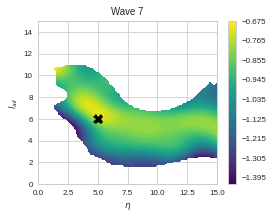

150it [02:58,  1.19s/it]
173it [00:00, 2467.36it/s]

New regression model coefficient of determination:  [0.22183374 0.25445107]


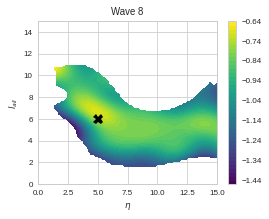

173it [02:58,  1.03s/it]
194it [00:00, 2312.01it/s]

New regression model coefficient of determination:  [0.21499681 0.25058185]


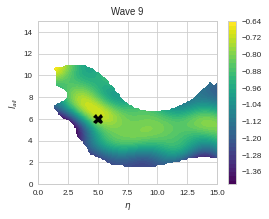

194it [02:42,  1.19it/s]
221it [00:00, 1579.56it/s]

New regression model coefficient of determination:  [0.22205913 0.24727187]


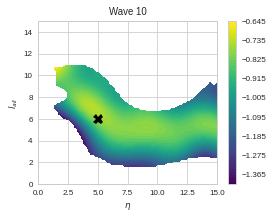

In [7]:
#2D inference of l_ali and eta: 
ndim = 2
p_start = np.array([0.0,0.0])
p_range = np.array([15.0,15.0]) 

# use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
y_previous = np.full((100,100),np.log(1e-18))

# number of waves
n_wave = 10 
n_points = 20 
T = 0.5

# number of points to add per wave
#n_points = 80
#T=0.05

abcGP = gp_abc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d) #synth_likelihood_function) #likelihood_function)


for i in range(n_wave):
    abcGP.runWave()
    plt.figure(figsize=(4,3))
    #plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='b',ms=4)
    abcGP.remove_implausible()
    #plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='r',ms=4)
    
    abcGP.update_rc()

    plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 
    # plot GP output
    xx, yy = np.meshgrid(X[0], X[1], sparse=False)
    x_grid = np.array([xx.flatten(), yy.flatten()])
    if i>0:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
    else:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=False)
    y_pred = y_pred.reshape(100,100)
    # for plotting we'll carry through the implausible regions from previous waves
    #y_pred[np.isinf(y_pred)]=y_previous[np.isinf(y_pred)]
    #y_previous = y_pred.copy()
    h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',vmax=min(0,np.max(y_pred)))  #0.1*
    ax = plt.gca()
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('$\eta$')
    plt.ylabel('$l_{ali}$')
    plt.title('Wave {}'.format(i+1))
    plt.colorbar()
    plt.savefig('zonal_macroscale_wave_normal_2D' + str(i) + '.png',dpi=300)

    plt.show()

## Previous versions below

.

.

.

.

.

.

.

In [ ]:

rc0 = np.load('/content/rc0_2d.npy')
rc1 = np.load('/content/rc1_2d.npy')



# Approach 1 - normal use of 1 summary statistic

100%|██████████| 5002/5002 [00:09<00:00, 504.82it/s]


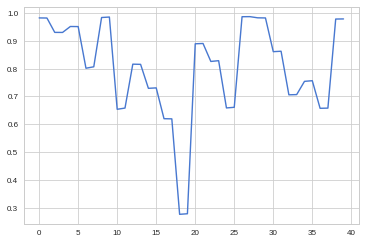

In [ ]:

L= 200
discard=5000 
N= 100 #500
repeat = 20 
timesteps = 2 
save_interval=1 #0 #1
dt=0.1 #1 #0.1
simulation_cls = zonal.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=repeat, dt=dt,save_interval=save_interval)

latt=6
lrep= 1
lali= 5
eta=0.9
va=2*pi
vs=5
sigma=0.1
simulation_cls.run_sim(eta, latt, lali, lrep, vs, va, sigma)

data_eta=eta
data_va=va
data_latt=latt
data_lali=lali
data_lrep=lrep
data_vs = vs
data_sigma = sigma

DATA_y = [data_lali,data_latt,data_lrep,data_eta,data_vs,data_va,data_sigma]


op, rot, ent, nnd, dis = simulation_cls.get_macro_states()
avgOPDATA=np.zeros(repeat)
avgROTDATA=np.zeros(repeat)
avgENTDATA=np.zeros(repeat)
avgNNDDATA=np.zeros(repeat)
avgDISDATA=np.zeros(repeat)

plt.plot(op)

for i in range(repeat):
    avgOPDATA[i] = op[((i+1)*(timesteps-1))-1]  
    avgROTDATA[i] = rot[((i+1)*(timesteps-1))-1] 
    avgENTDATA[i] = ent[((i+1)*(timesteps-1))-1] 
    avgNNDDATA[i] = nnd[((i+1)*(timesteps-1))-1] 
    avgDISDATA[i] = dis[((i+1)*(timesteps-1))-1] 




In [ ]:

theta_DATA0 = np.mean(avgOPDATA) 
sd0 =  np.std(avgOPDATA) 

In [ ]:
def abc_likelihood_2d(sim_output,params=None):
    
    theta_0 = sim_output[:,-1]

    repeat = sim_output.shape[0]
    diffmean = theta_0-theta_DATA0   

    return np.log(1e-18 + 1/repeat * sd0 *np.sqrt(2*pi)*np.sum(scipy.stats.norm(0,sd0).pdf(diffmean)))    
    
    

def simulator_2d(params):
    repeat = 50    
    simulation_cls = zonal.zonal_model(N,timesteps+discard,discard=discard,repeat=repeat,L=L,dt=dt, save_interval=1,disable_progress=True) 

    simulation_cls.run_sim(eta, params[1], params[0],lrep, vs, va, sigma)  
    sim_output, _, _, _, _ = simulation_cls.get_macro_states() 
    
    return np.reshape(sim_output, (repeat,timesteps))
  


0it [00:00, ?it/s]
1it [00:15, 15.69s/it]
2it [00:31, 15.70s/it]
3it [00:47, 15.71s/it]
4it [01:02, 15.71s/it]
5it [01:17, 15.52s/it]
6it [01:33, 15.59s/it]
7it [01:49, 15.63s/it]
8it [02:05, 15.66s/it]
9it [02:20, 15.59s/it]
10it [02:36, 15.59s/it]
11it [02:51, 15.62s/it]
12it [03:07, 15.65s/it]
13it [03:22, 15.54s/it]
14it [03:38, 15.58s/it]
15it [03:53, 15.52s/it]
16it [04:09, 15.56s/it]
17it [04:24, 15.47s/it]
18it [04:40, 15.54s/it]
19it [04:56, 15.62s/it]
20it [05:11, 15.60s/it]


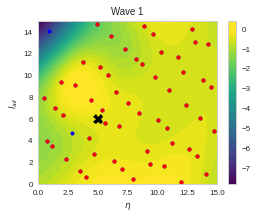


0it [00:00, ?it/s]
19it [00:15,  1.23it/s]
20it [00:31,  5.28s/it]
21it [00:46,  8.36s/it]
22it [01:02, 10.47s/it]
23it [01:17, 12.03s/it]
24it [01:33, 13.08s/it]
25it [01:49, 13.92s/it]
26it [02:04, 14.30s/it]
27it [02:19, 14.69s/it]
28it [02:35, 14.83s/it]
29it [02:50, 14.94s/it]
30it [03:05, 15.09s/it]
31it [03:21, 15.25s/it]
32it [03:37, 15.40s/it]
33it [03:52, 15.50s/it]
34it [04:08, 15.45s/it]
35it [04:23, 15.54s/it]
36it [04:39, 15.52s/it]
37it [04:54, 15.51s/it]
38it [05:10, 15.58s/it]
39it [05:26, 15.57s/it]
40it [05:41, 15.63s/it]
41it [05:57, 15.47s/it]
42it [06:12, 15.56s/it]
43it [06:28, 15.53s/it]
44it [06:43, 15.51s/it]
45it [06:59, 15.51s/it]
46it [07:14, 15.56s/it]
47it [07:30, 15.64s/it]
48it [07:45, 15.50s/it]
49it [08:01, 15.56s/it]
50it [08:17, 15.64s/it]
51it [08:33, 15.68s/it]
52it [08:48, 15.57s/it]
53it [09:04, 15.62s/it]
54it [09:20, 15.65s/it]
55it [09:35, 10.46s/it]


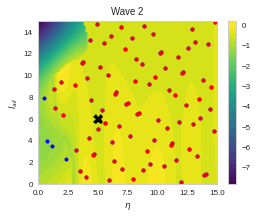


0it [00:00, ?it/s]
52it [00:15,  3.37it/s]
53it [00:31,  4.94s/it]
54it [00:46,  8.11s/it]
55it [01:02, 10.39s/it]
56it [01:18, 11.99s/it]
57it [01:33, 13.04s/it]
58it [01:49, 13.78s/it]
59it [02:04, 14.39s/it]
60it [02:20, 14.75s/it]
61it [02:35, 14.91s/it]
62it [02:51, 15.12s/it]
63it [03:07, 15.28s/it]
64it [03:22, 15.43s/it]
65it [03:38, 15.35s/it]
66it [03:53, 15.43s/it]
67it [04:09, 15.47s/it]
68it [04:24, 15.45s/it]
69it [04:40, 15.53s/it]
70it [04:55, 15.56s/it]
71it [05:11, 15.60s/it]
72it [05:26, 15.43s/it]
73it [05:42, 15.53s/it]
74it [05:58, 15.60s/it]
75it [06:13, 15.53s/it]
76it [06:29, 15.54s/it]
77it [06:44, 15.59s/it]
78it [07:00, 15.63s/it]
79it [07:15, 15.53s/it]
80it [07:31, 15.57s/it]
81it [07:47, 15.55s/it]
82it [08:02, 15.64s/it]
83it [08:18, 15.67s/it]
84it [08:34,  6.12s/it]


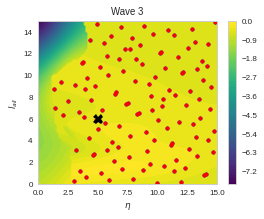

In [ ]:
#2D inference of l_ali and eta: 
ndim = 2
p_start = np.array([0.0,0.0])
p_range = np.array([15.0,15.0]) 

# use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
y_previous = np.full((100,100),np.log(1e-18))

# number of waves
n_wave = 3
n_points = 20 
T = 0.5

# number of points to add per wave
#n_points = 80
#T=0.05

abcGP = gp_abc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d) #synth_likelihood_function) #likelihood_function)


for i in range(n_wave):
    abcGP.runWave()
    plt.figure(figsize=(4,3))
    plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='b',ms=4)
    abcGP.remove_implausible()
    plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='r',ms=4)
    

    plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 
    # plot GP output
    xx, yy = np.meshgrid(X[0], X[1], sparse=False)
    x_grid = np.array([xx.flatten(), yy.flatten()])
    if i>0:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
    else:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=False)
    y_pred = y_pred.reshape(100,100)
    # for plotting we'll carry through the implausible regions from previous waves
    y_pred[np.isinf(y_pred)]=y_previous[np.isinf(y_pred)]
    y_previous = y_pred.copy()
    h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',vmax=min(0,np.max(y_pred)))  #0.1*
    ax = plt.gca()
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('$\eta$')
    plt.ylabel('$l_{ali}$')
    plt.title('Wave {}'.format(i+1))
    plt.colorbar()
    plt.savefig('zonal_macroscale_wave_normal_2D' + str(i) + '.png',dpi=300)

    plt.show()

In [ ]:
#am_sampler:

startval = abcGP.sobel_points[np.random.choice(abcGP.sobel_points.shape[0])]
prior = np.array(((0.0,15.0),(0.0,15.0)))  
print(startval)
# step size is 1/50th of the plausible range
steps = np.ptp(abcGP.sobel_points,axis=0)/50
import time
start = time.time()
samples = am_sampler.am_sampler(abcGP.predict_final,2,startval,prior,steps, n_samples=20000, burn_in=1000, m=10)

In [ ]:
# def clean(serie):
#     output = serie[(np.isnan(serie) == False) & (np.isinf(serie) == False)]
#     return output

# samples = clean(samples)    

In [ ]:
np.shape(samples)

(20000, 2)

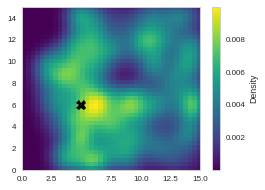

In [ ]:
plt.figure(figsize=(4,3))
# fit an array of size [Ndim, Nsamples]
data = np.vstack([samples[:,0],samples[:,1]])
kde = gaussian_kde(data)

# evaluate on a regular grid
#0.55,0.8,0.15,0.25
xgrid = np.linspace(0.0, 15.0, 40) # 0.99, 40)
ygrid = np.linspace(0.0,15.0, 40) #0.3, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent= [0.0,15.0,0.0,15.0] ,
           cmap='viridis') #[0.55,0.99,0.15,0.3],
plt.grid(False)
cb = plt.colorbar()
cb.set_label("Density")
plt.savefig('kde_normal_2D.png',bbox_inches = 'tight',dpi=300)
plt.show()



In [ ]:
np.isnan(samples).any()
np.isinf(samples).any()

False

# Approach 2 - using regression coefficients

In [ ]:

ss_0 = rc0[0]*(avgOPDATA) + rc0[1]*(avgROTDATA) + rc0[2]*(avgENTDATA) + rc0[3]*(avgNNDDATA) + rc0[4]*(avgDISDATA)
theta_DATA0 = np.mean(ss_0) 
sd0 =  np.std(ss_0) 

ss_1 = rc1[0]*(avgOPDATA) + rc1[1]*(avgROTDATA) + rc1[2]*(avgENTDATA) + rc1[3]*(avgNNDDATA) + rc1[4]*(avgDISDATA)
theta_DATA1 = np.mean(ss_1) 
sd1 =  np.std(ss_1) 

T_2d = np.sqrt(sd0**2+sd1**2)

In [ ]:
def abc_likelihood_2d(sim_output,params=None):
    #collecting sum stats:
    sim_output1 = sim_output[0]
    sim_output2 = sim_output[1]
    sim_output3 = sim_output[2]
    sim_output4 = sim_output[3]
    sim_output5 = sim_output[4]

    
    theta_0 = rc0[0]*sim_output1[:,-1] + rc0[1]*sim_output2[:,-1] + rc0[2]*sim_output3[:,-1] + rc0[3]*sim_output4[:,-1] + rc0[4]*sim_output5[:,-1]
    theta_1 = rc1[0]*sim_output1[:,-1] + rc1[1]*sim_output2[:,-1] + rc1[2]*sim_output3[:,-1] + rc1[3]*sim_output4[:,-1] + rc1[4]*sim_output5[:,-1]

    repeat = sim_output1.shape[0]
    diff_2d = np.sqrt((theta_0-theta_DATA0)**2 + (theta_1-theta_DATA1)**2) 
T_2d = np.sqrt(sd0**2+sd1**2)
    return np.log(1e-18 + 1/repeat * T_2d *np.sqrt(2*pi)*np.sum(scipy.stats.norm(0,T_2d).pdf(diff_2d)))   
    
    

def simulator_2d(params):
    repeat = 10 #50    
    simulation_cls = zonal.zonal_model(N,timesteps+discard,discard=discard,repeat=repeat,L=L,dt=dt, save_interval=1,disable_progress=True) 

    simulation_cls.run_sim(eta, params[1], params[0],lrep, vs, va, sigma)  
    sim_output1, sim_output2, sim_output3, sim_output4, sim_output5 = simulation_cls.get_macro_states() 
    
    return [np.reshape(sim_output1,(repeat,timesteps)),np.reshape(sim_output2,(repeat,timesteps)),np.reshape(sim_output3,(repeat,timesteps)),np.reshape(sim_output4,(repeat,timesteps)),np.reshape(sim_output5,(repeat,timesteps))]
  

In [ ]:
#2D inference of l_ali and eta: 
ndim = 2
p_start = np.array([0.0,0.0])
p_range = np.array([15.0,15.0]) 

# use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
y_previous = np.full((100,100),np.log(1e-18))

# number of waves
n_wave = 3
n_points = 20 
T = 0.1

abcGP = gp_abc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d) 


for i in range(n_wave):
    abcGP.runWave()
    plt.figure(figsize=(4,3))
    plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='b',ms=4)
    abcGP.remove_implausible()
    plt.plot(abcGP.sobel_points[:,0],abcGP.sobel_points[:,1],'o',c='r',ms=4)
    

    plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 
    # plot GP output
    xx, yy = np.meshgrid(X[0], X[1], sparse=False)
    x_grid = np.array([xx.flatten(), yy.flatten()])
    if i>0:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
    else:
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=False)
    y_pred = y_pred.reshape(100,100)
    # for plotting we'll carry through the implausible regions from previous waves
    y_pred[np.isinf(y_pred)]=y_previous[np.isinf(y_pred)]
    y_previous = y_pred.copy()
    h = plt.contourf(X[0], X[1], y_pred,50,cmap='viridis',vmax=min(0,np.max(y_pred)))  #0.1*
    ax = plt.gca()
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('$\eta$')
    plt.ylabel('$l_{ali}$')
    plt.title('Wave {}'.format(i+1))
    plt.colorbar()
    plt.savefig('zonal_2D_LR_macroscale_wave' + str(i) + '.png',dpi=300)

    plt.show()

In [ ]:
#am_sampler:

startval = abcGP.sobel_points[np.random.choice(abcGP.sobel_points.shape[0])]
prior = np.array(((0.0,15.0),(0.0,15.0)))  
print(startval)
# step size is 1/50th of the plausible range
steps = np.ptp(abcGP.sobel_points,axis=0)/50
import time
start = time.time()
samples = am_sampler.am_sampler(abcGP.predict_final,2,startval,prior,steps, n_samples=20000, burn_in=1000, m=10)

In [ ]:
def clean(serie):
    output = serie[(np.isnan(serie) == False) & (np.isinf(serie) == False)]
    return output

samples = clean(samples)    

In [ ]:
startval

array([11.484375,  8.203125])

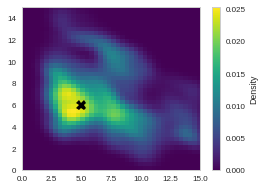

In [ ]:
plt.figure(figsize=(4,3))
# fit an array of size [Ndim, Nsamples]
data = np.vstack([samples[:,0],samples[:,1]])
kde = gaussian_kde(data)

# evaluate on a regular grid
#0.55,0.8,0.15,0.25
xgrid = np.linspace(0.0, 15.0, 40) # 0.99, 40)
ygrid = np.linspace(0.0,15.0, 40) #0.3, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
plt.plot(data_lali,data_latt,'X',c='k',markersize=10) 

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent= [0.0,15.0,0.0,15.0] ,
           cmap='viridis') #[0.55,0.99,0.15,0.3],
# plt.contourf(Z.reshape(Xgrid.shape),
#            origin='lower', aspect='auto',
#            extent= [0.0,15.0,0.0,15.0] ,
#            cmap='viridis') #[0.55,0.99,0.15,0.3],
plt.grid(False)
cb = plt.colorbar()
cb.set_label("Density")
plt.savefig('kde_LR_2D.png',bbox_inches = 'tight',dpi=300)
plt.show()



In [63]:

import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy import stats

import pickle



from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from spektral.layers import ECCConv, GlobalAvgPool, MessagePassing, XENetConv, GlobalAttentionPool, GlobalMaxPool, GlobalSumPool,GlobalAttnSumPool

plt.style.use('ggplot')
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 



#************************************
#************************************
#********DATA LOADER*****************
#************************************
#************************************
#************************************

train_dir = 'train_datasets/'
valid_dir = 'valid_datasets/'

BATCH_SIZE=64
EPOCHS=200

all_file_list = [train_dir + filename for filename in os.listdir(train_dir)]

dataset_size = sum(1 for _ in tf.data.TFRecordDataset(all_file_list[0]))*len(all_file_list)//BATCH_SIZE


feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'timestep': tf.io.FixedLenFeature([], tf.int64),
                        'parameter_vector': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string),
                        'acc': tf.io.FixedLenFeature([], tf.string)}

def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'timestep': x['timestep'],
                'parameter_vector': x['parameter_vector'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32),
                'acc': tf.io.parse_tensor(x['acc'],out_type=tf.float32)}
    return output

def _parse_keras(x):
    pos = x['pos']
    #pos.set_shape((None,2))
    vel = x['vel']
    #vel.set_shape((None,2))
    acc = x['acc']
    #acc.set_shape((None,2))
    
    target = x['parameter_vector'][1:3]
    #target.set_shape((4))
    output = ((pos,vel,acc),target)
    return output


DOMAIN_SIZE=100.
MAX_RADIUS=25.

max_params = np.array([25.0,25.0],dtype=np.float32)

def _parse_graph(inputs, targets):
    #inputs, targets = x
    X, V, A = inputs
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx)
    dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy)
    dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy)

    Vx = tf.expand_dims(V[...,0],-1)
    dvx = -Vx + tf.linalg.matrix_transpose(Vx)

    Vy = tf.expand_dims(V[...,1],-1)
    dvy = -Vy + tf.linalg.matrix_transpose(Vy)
    
    dvnorm = tf.math.sqrt(dvx**2+dvy**2)
    dvx = tf.math.divide_no_nan(dvx,dvnorm)
    dvy = tf.math.divide_no_nan(dvy,dvnorm)

    angles = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - angles

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    adj_matrix = tf.where(dist<MAX_RADIUS, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
    output_ie = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_edge)


    senders =tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

    output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
    edge_distance = tf.expand_dims(tf.gather_nd(dist/MAX_RADIUS, sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
    edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

    edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
    edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


    output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)

    node_velocities = tf.reshape(V,(-1,2))
    node_accelerations = tf.reshape(A,(-1,2))

    #output_x = tf.concat([node_velocities,node_accelerations],axis=-1)
    output_x = node_velocities

    return (output_x, output_a, output_e, output_i,output_ie), targets#/max_params
    
    
    

train_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([train_dir + filename for filename in os.listdir(train_dir)]))

parsed_train_dataset = train_dataset.map(_parse_record)
parsed_train_dataset = parsed_train_dataset.map(_parse_tensor)
parsed_train_dataset = parsed_train_dataset.map(_parse_keras)


parsed_train_dataset = parsed_train_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_train_dataset = parsed_train_dataset.repeat(EPOCHS)
parsed_train_dataset = parsed_train_dataset.batch(BATCH_SIZE, drop_remainder=True)

parsed_train_dataset = parsed_train_dataset.map(_parse_graph)


valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_valid_dataset = valid_dataset.map(_parse_record)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_keras)
parsed_valid_dataset = parsed_valid_dataset.batch(64, drop_remainder=True)
#parsed_valid_dataset = parsed_valid_dataset.map(_parse_graph)




In [2]:

gnn_model = tf.keras.models.load_model('gnn/gnn_model')

#************************************
#************************************
#********SAVE FIGURE*****************
#************************************
#************************************
#************************************



In [30]:
#databatch[0]

In [40]:
X2,V2,A2 = databatch[0]

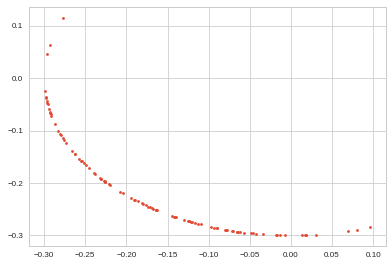

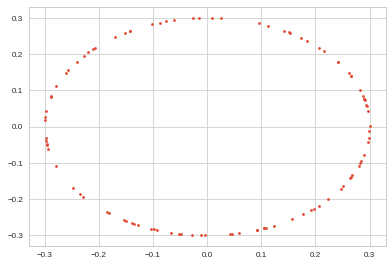

In [71]:
plt.plot(V2.numpy()[0,...,0],V2.numpy()[0,...,1],'.')
plt.show()
plt.plot(V[0,...,0],V[0,...,1],'.')
plt.show()

In [56]:
# databatch[0]

In [64]:



pred_list = []
true_values = []
for databatch in tqdm(parsed_valid_dataset):

    target = databatch[1]
    true_values.append(target.numpy())

    parsed, _ = _parse_graph(databatch[0],databatch[1])
    predictions = gnn_model(parsed)
    pred_list.append(np.squeeze(predictions.numpy()))
    break


0it [00:00, ?it/s]


In [76]:
parsed2, _ = _parse_graph((databatch[0][0][0,None],databatch[0][1][0,None],databatch[0][2][0,None]),databatch[1][0,None])
gnn_model(parsed2)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[38.516594, 59.237396]], dtype=float32)>

In [78]:
parsed2

(<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
 array([[ 0.01437431,  0.29965544],
        [-0.28833362, -0.0828476 ],
        [-0.02820538,  0.2986712 ],
        [-0.259326  ,  0.15083112],
        [-0.28933614, -0.07927553],
        [-0.22719565,  0.19591363],
        [-0.28662664, -0.08857311],
        [-0.29698265, -0.04244205],
        [ 0.19069609,  0.23159236],
        [ 0.19675182,  0.22647019],
        [ 0.21188366,  0.21238014],
        [-0.17367935,  0.24461293],
        [-0.29337192,  0.06271304],
        [ 0.05056475,  0.295708  ],
        [-0.26346052, -0.14348717],
        [ 0.12464522,  0.27288017],
        [-0.26929593, -0.13221084],
        [-0.1808997 ,  0.23932262],
        [-0.29754433, -0.03830641],
        [-0.22278818,  0.2009115 ],
        [-0.297046  ,  0.04199615],
        [-0.25997522,  0.14970934],
        [ 0.16452655,  0.25086057],
        [-0.27654326,  0.11629198],
        [-0.28779733,  0.0846918 ],
        [-0.04762398,  0.2961958 ],
        [-0.2

In [102]:
onebatch = [parsed[0][:100], tf.sparse.SparseTensor(    indices=parsed[1].indices[:6908], values=parsed[1].values[:6908], dense_shape=(100,100)),parsed[2][:6908],parsed[3][:100], parsed[4][:6908]]




In [158]:
MLP_SIZE=16
n_out=2
l1 = Dense(MLP_SIZE, activation="linear")#(onebatch[0])#(X_in)
l2 = Dense(MLP_SIZE, activation="linear")#(E_in)


l3 = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="tanh", edge_activation="tanh")#([X, A_in, E])
l4 = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="tanh", edge_activation="tanh")#([X, A_in, E])

l5 = Dense(MLP_SIZE, activation="linear",use_bias=False)#(X)
l6 = Concatenate()#([X, X_in])
l7 = GlobalAttentionPool(MLP_SIZE)#([X, I_in])
l8 = GlobalMaxPool()#([X, I_in])
l9 = GlobalAvgPool()#([X, I_in])
l10 = Concatenate()#([Xs,Xm,Xa])#, Es,Em,Ea])
l11 = Dense(MLP_SIZE, activation="linear",use_bias=False)#(X)
l12 = Dense(n_out, activation="softplus",use_bias=False)#(X)


In [159]:
l1all = l1(parsed[0])
l1one = l1(onebatch[0])
l2all = l2(parsed[2])
l2one = l2(onebatch[2])
l3alln,l3alle = l3([l1all,parsed[1],l2all])
l3onen,l3onee = l3([l1one,onebatch[1],l2one])

l4alln,l4alle = l4([l3alln,parsed[1],l3alle])
l4onen,l4onee = l4([l3onen,onebatch[1],l3onee])

l5all = l5(l4alln)
l5one = l5(l4onen)

l6all = l6([l5all,parsed[0]])
l6one = l6([l5one,onebatch[0]])

l7all = l7([l6all,parsed[3]])
l7one = l7([l6one,onebatch[3]])

l8all = l8([l6all,parsed[3]])
l8one = l8([l6one,onebatch[3]])

l9all = l9([l6all,parsed[3]])
l9one = l9([l6one,onebatch[3]])

l10all = l10([l7all,l8all,l9all])
l10one = l10([l7one,l8one,l9one])

l11all = l11(l10all)
l11one = l11(l10one)

l12all = l12(l11all)
l12one = l12(l11one)

In [160]:
l12all[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.3216674e-04, 1.5734361e-16], dtype=float32)>

In [161]:
l12one

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.3216585e-04, 1.5734301e-16]], dtype=float32)>

In [135]:
l4onen

<tf.Tensor: shape=(100, 16), dtype=float32, numpy=
array([[ 0.99999934,  0.99999064, -1.        , ..., -0.973353  ,
         1.        ,  0.9926207 ],
       [-0.9990719 ,  1.        , -1.        , ...,  0.78949565,
         0.9977686 ,  0.96060705],
       [ 0.9913436 ,  1.        , -1.        , ...,  0.7975222 ,
         0.98718274,  0.1652612 ],
       ...,
       [ 0.95937073,  1.        , -1.        , ...,  0.8743276 ,
         0.9981001 ,  0.999988  ],
       [-0.25124124,  1.        , -1.        , ...,  0.9985729 ,
         0.8624523 ,  0.9998022 ],
       [ 0.12810701,  0.99999905, -1.        , ..., -0.93207496,
         0.65720654,  0.99452275]], dtype=float32)>

In [ ]:

n_out = 2
n_feat_node=2
n_feat_edge=5

MLP_SIZE=16

X_in = Input(shape=(n_feat_node,))
A_in = Input(shape=(None,), sparse=True)
E_in = Input(shape=(n_feat_edge,))
I_in = Input(shape=(), dtype=tf.int64)
IE_in = Input(shape=(), dtype=tf.int64)



X = Dense(MLP_SIZE, activation="linear")(X_in)
E = Dense(MLP_SIZE, activation="linear")(E_in)


X, E = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
X, E = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="tanh", edge_activation="tanh")([X, A_in, E])

X = Dense(MLP_SIZE, activation="linear",use_bias=False)(X)
# E = Dense(MLP_SIZE, activation="linear",use_bias=False)(E)


X = Concatenate()([X, X_in])
E = Concatenate()([E, E_in])

Xs = GlobalAttnSumPool()([X, I_in])
Xm = GlobalMaxPool()([X, I_in])
Xa = GlobalAvgPool()([X, I_in])

# Es = GlobalAttnSumPool()([E, IE_in])
# Em = GlobalMaxPool()([E, IE_in])
# Ea = GlobalAvgPool()([E, IE_in])

X = Concatenate()([Xs,Xm,Xa])#, Es,Em,Ea])

X = Dense(MLP_SIZE, activation="linear",use_bias=False)(X)

output = Dense(n_out, activation="softplus",use_bias=False)(X)

gnn_model = Model(inputs=[X_in, A_in, E_in, I_in, IE_in], outputs=output)


In [103]:
gnn_model(onebatch)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[38.516594, 59.237408]], dtype=float32)>

In [77]:
parsed, _ = _parse_graph(databatch[0],databatch[1])
gnn_model(parsed)

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[13.344931 , 14.7177105],
       [13.596072 , 14.185583 ],
       [15.299833 , 19.143139 ],
       [ 5.1333637, 13.365931 ],
       [ 7.5257607, 17.181408 ],
       [14.987265 , 15.585957 ],
       [ 6.5179462, 13.591575 ],
       [13.446081 , 14.40859  ],
       [15.628838 , 19.171057 ],
       [14.325376 , 14.407855 ],
       [ 3.7051249, 11.14754  ],
       [ 7.9543233,  9.122115 ],
       [ 7.2146373, 16.650042 ],
       [14.76268  , 15.678203 ],
       [ 4.946589 , 14.106095 ],
       [10.640108 , 16.334063 ],
       [15.613451 , 18.239164 ],
       [ 7.1506896, 14.8197775],
       [15.358921 , 19.031816 ],
       [15.439043 , 16.614805 ],
       [15.672497 , 19.054495 ],
       [ 6.478196 ,  9.856241 ],
       [ 9.583795 , 14.352394 ],
       [16.675043 , 19.994019 ],
       [15.809605 , 18.083351 ],
       [ 6.0572815, 16.807987 ],
       [15.284147 , 19.74187  ],
       [16.325874 , 19.780212 ],
       [10.962013 , 17.2780

In [44]:
gnn_model(databatch[0])

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[16.007584 , 21.122353 ],
       [16.802738 , 20.5011   ],
       [14.368331 , 18.48865  ],
       [15.317165 , 18.836296 ],
       [16.0566   , 20.66017  ],
       [16.234295 , 20.189045 ],
       [16.007233 , 18.77025  ],
       [15.96269  , 19.08432  ],
       [12.35277  , 19.616909 ],
       [17.241693 , 21.094423 ],
       [15.553061 , 17.2372   ],
       [15.669809 , 20.02892  ],
       [17.223665 , 20.491755 ],
       [17.079073 , 20.92335  ],
       [15.144347 , 17.4717   ],
       [13.939443 , 18.56768  ],
       [16.860899 , 21.16781  ],
       [17.175415 , 20.711916 ],
       [15.931131 , 19.46346  ],
       [16.290482 , 19.814419 ],
       [14.466744 , 16.668406 ],
       [16.914986 , 19.632206 ],
       [17.207344 , 20.065437 ],
       [16.373903 , 20.77782  ],
       [16.653202 , 19.474794 ],
       [17.094307 , 20.247578 ],
       [14.327099 , 17.373592 ],
       [16.406042 , 19.6876   ],
       [16.518217 , 20.9215

In [41]:
predictions
#true_values

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[16.007584 , 21.12235  ],
       [16.80274  , 20.501102 ],
       [14.36833  , 18.48865  ],
       [15.317165 , 18.836296 ],
       [16.056602 , 20.660172 ],
       [16.234295 , 20.189045 ],
       [16.007235 , 18.770248 ],
       [15.962693 , 19.08432  ],
       [12.352771 , 19.61691  ],
       [17.241695 , 21.094425 ],
       [15.5530615, 17.237202 ],
       [15.669813 , 20.02892  ],
       [17.223663 , 20.491753 ],
       [17.079071 , 20.92335  ],
       [15.144348 , 17.4717   ],
       [13.939442 , 18.567678 ],
       [16.860897 , 21.167809 ],
       [17.175415 , 20.711916 ],
       [15.931131 , 19.46346  ],
       [16.29048  , 19.814419 ],
       [14.466747 , 16.668407 ],
       [16.914986 , 19.632204 ],
       [17.207344 , 20.065437 ],
       [16.373905 , 20.77782  ],
       [16.653202 , 19.474796 ],
       [17.094307 , 20.247578 ],
       [14.327095 , 17.373594 ],
       [16.40604  , 19.687597 ],
       [16.518217 , 20.9215

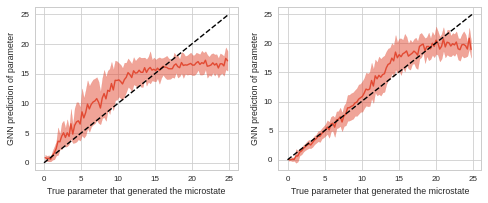

In [12]:




fig, axs = plt.subplots(1,2, figsize=(8, 3), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(2):

    pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(0,true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')



plt.savefig('gnn_valid.png',dpi=300)
